In [53]:
import joblib
import pickle
import base64
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import RandomOverSampler
import matplotlib

In [54]:
df=pd.read_csv('spam_dataset.csv',encoding='latin-1')
df.head()

,label,text
0,spam,naturally irresistible your corporate identity...
1,spam,the stock trading gunslinger fanny is merrill ...
2,spam,unbelievable new homes made easy im wanting to...
3,spam,4 color printing special request additional in...
4,spam,do not have money get software cds from here s...


In [55]:
df.shape

(20348, 2)

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20348 entries, 0 to 20347
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   20348 non-null  object
 1   text    20348 non-null  object
dtypes: object(2)
memory usage: 318.1+ KB


In [57]:
df['text']

0        naturally irresistible your corporate identity...
1        the stock trading gunslinger fanny is merrill ...
2        unbelievable new homes made easy im wanting to...
3        4 color printing special request additional in...
4        do not have money get software cds from here s...
                               ...                        
20343                                                 /ban
20344                                                 /ban
20345                                                 /ban
20346                                            Kaisi hii
20347                                              Shock q
Name: text, Length: 20348, dtype: object

In [58]:
df.drop_duplicates(inplace=True)

In [59]:
spam_count = len(df[df['label'] == 'spam'])
ham_count = len(df[df['label'] == 'ham'])
total_messages = len(df)
spam_percentage = (spam_count / total_messages) * 100
ham_percentage = (ham_count / total_messages) * 100
print(f"spam_count: {spam_count}")
print(f"ham_count: {ham_count}")
print(f"total_messages: {total_messages}")


spam_count: 6011
ham_count: 14323
total_messages: 20334


(-1.1840870762563476,
 1.104003570880801,
 -1.1029919364543506,
 1.1628821183506632)

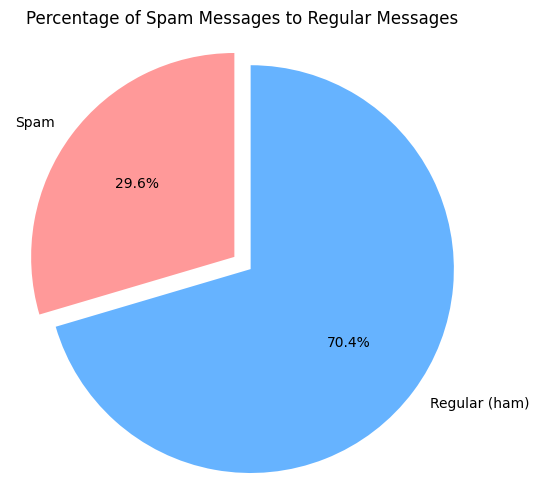

In [60]:
labels = ['Spam', 'Regular (ham)']
sizes = [spam_percentage, ham_percentage]
colors = ['#ff9999', '#66b3ff']
explode = (0.1, 0)

plt.figure(figsize=(6, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Percentage of Spam Messages to Regular Messages')
plt.axis('equal')

<Axes: xlabel='label'>

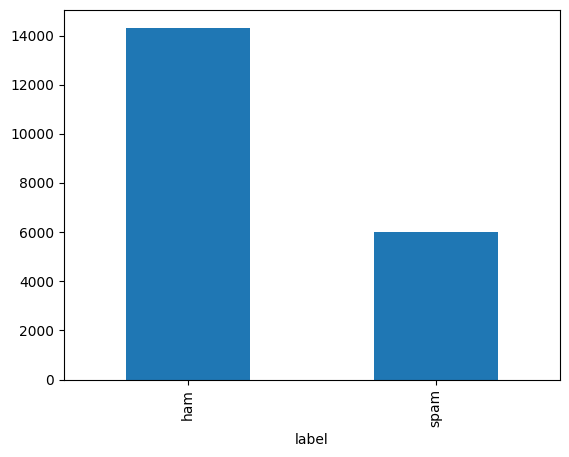

In [61]:
df['label'].value_counts().plot.bar()

Text(0.5, 1.0, 'Distribution of Number of Characters in Messages')

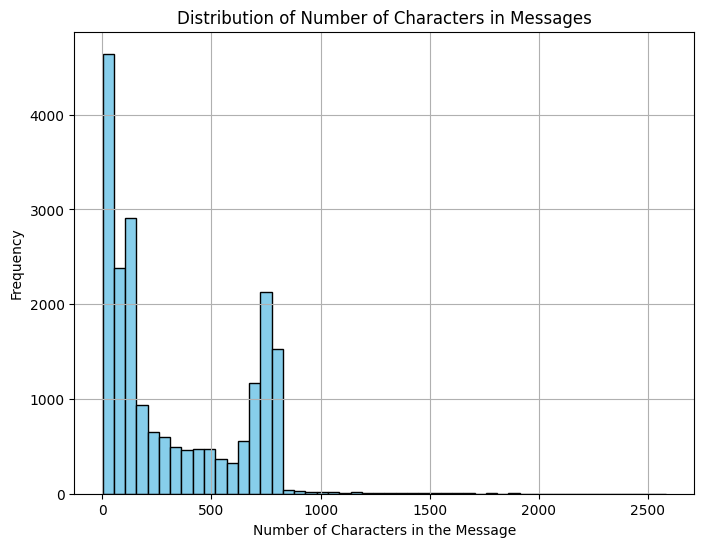

In [62]:
df['number_of_characters_in_the_message'] = df['text'].apply(len)
plt.figure(figsize=(8, 6))
df['number_of_characters_in_the_message'].hist(bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Number of Characters in the Message')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Characters in Messages')

# Data PreProcessing

In [63]:
def lowerChange(text):
    return text.lower() 

df['']=df['text'].apply(lowerChange)
df['text']

0        naturally irresistible your corporate identity...
1        the stock trading gunslinger fanny is merrill ...
2        unbelievable new homes made easy im wanting to...
3        4 color printing special request additional in...
4        do not have money get software cds from here s...
                               ...                        
20333    SPAM ALERT  ð  User:     Username: @DillyBu...
20341                                             Hum ky h
20342                                                 /ban
20346                                            Kaisi hii
20347                                              Shock q
Name: text, Length: 20334, dtype: object

In [64]:
df.drop('text',axis=1,inplace=True)


1=Spam
0=Ham

In [65]:
df = pd.read_csv('spam_dataset.csv', skiprows=1, names=['label', 'text'])
df['label'] = df['label'].map({'spam': 1, 'ham': 0})

# Vectorize Text

In [66]:
df.head()

,label,text
0,1,naturally irresistible your corporate identity...
1,1,the stock trading gunslinger fanny is merrill ...
2,1,unbelievable new homes made easy im wanting to...
3,1,4 color printing special request additional in...
4,1,do not have money get software cds from here s...


# DATA SPLITTING

In [67]:
train_data, temp_data, train_labels, temp_labels = train_test_split(
    df['text'], df['label'], test_size=0.2, random_state=100
)

test_data, cv_data, test_labels, cv_labels = train_test_split(
    temp_data, temp_labels, test_size=0.5, random_state=100
)

# RESAMPLING

In [68]:
vectorizer = CountVectorizer(max_features=400)
train_data_numeric = vectorizer.fit_transform(train_data).toarray()
test_data_numeric = vectorizer.transform(test_data).toarray()

ros = RandomOverSampler(random_state=42)
train_data_resampled, train_labels_resampled = ros.fit_resample(train_data_numeric, train_labels)
scaler = MinMaxScaler()
train_data_normalized = scaler.fit_transform(train_data_resampled)
test_data_normalized = scaler.transform(test_data_numeric)

class_weights = {
    0: 1.0,
    1: 1.3
}

# MODELLING

In [69]:
tf.random.set_seed(1234)

model = Sequential([
    Dense(128, activation='relu', input_shape=(400,), name="L1"),
    Dropout(0.5),
    Dense(64, activation='relu', name="L2"),
    Dropout(0.3),
    Dense(32, activation='relu', name="L3"),
    Dropout(0.3),
    Dense(1, activation='sigmoid', name="Output"),
], name="my_model")

initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=10000, decay_rate=0.9, staircase=True
)

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=Adam(learning_rate=lr_schedule),
    metrics=['accuracy']
)

In [70]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [71]:
model_checkpoint = ModelCheckpoint(
    'spam_classifier_model.h5',
    save_best_only=True,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    verbose=1
)

# TRAINING 

In [72]:
def data_generator(data, labels, batch_size):
    num_samples = len(data)
    while True:
        indices = np.random.choice(num_samples, batch_size, replace=False)
        yield data[indices], np.array(labels[indices])[:, np.newaxis]


In [73]:
# Clear session before starting
tf.keras.backend.clear_session()

# Training loop
batch_size = 65
steps_per_epoch = len(train_data_normalized) // batch_size

epochs = 60
history_list = []

for epoch in range(epochs):
    history = model.fit(
        data_generator(train_data_normalized, train_labels_resampled, batch_size),
        epochs=1,
        steps_per_epoch=steps_per_epoch,
        validation_data=(test_data_normalized, np.array(test_labels.values)[:, np.newaxis]),
        callbacks=[early_stopping, model_checkpoint],
        class_weight=class_weights
    )

    history_list.append(history.history)

# Save training history
with open('training_history.pkl', 'wb') as file:
    pickle.dump(history_list, file)

# Save model in the native Keras format
model.save('my_model.keras')

# Save model in TensorFlow SavedModel format
model.save('my_model_tf')

# Load the model from the TensorFlow SavedModel format
loaded_model = tf.keras.models.load_model('my_model_tf')

# Make predictions and evaluate
train_pred_prob = loaded_model.predict(train_data_normalized)
test_pred_prob = loaded_model.predict(test_data_normalized)

train_pred = (train_pred_prob > 0.5).astype(int)
test_pred = (test_pred_prob > 0.5).astype(int)

print('Train Accuracy - ', accuracy_score(train_labels_resampled, train_pred))
print("Test Accuracy - ", accuracy_score(test_labels, test_pred))

353/353 [==============================] - ETA: 0s - loss: 0.7786 - accuracy: 0.5555
Epoch 1: val_loss improved from inf to 0.68833, saving model to spam_classifier_model.h5


c:\Users\JHING\Desktop\nn_withflask\.env\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


352/353 [============================>.] - ETA: 0s - loss: 0.6554 - accuracy: 0.6658
Epoch 1: val_loss improved from 0.68833 to 0.50172, saving model to spam_classifier_model.h5


c:\Users\JHING\Desktop\nn_withflask\.env\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


353/353 [==============================] - ETA: 0s - loss: 0.4998 - accuracy: 0.7786
Epoch 1: val_loss improved from 0.50172 to 0.40504, saving model to spam_classifier_model.h5
353/353 [==============================] - 7s 19ms/step - loss: 0.4998 - accuracy: 0.7786 - val_loss: 0.4050 - val_accuracy: 0.8064


c:\Users\JHING\Desktop\nn_withflask\.env\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


351/353 [============================>.] - ETA: 0s - loss: 0.4395 - accuracy: 0.8166
Epoch 1: val_loss improved from 0.40504 to 0.36212, saving model to spam_classifier_model.h5


c:\Users\JHING\Desktop\nn_withflask\.env\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


352/353 [============================>.] - ETA: 0s - loss: 0.4212 - accuracy: 0.8266
Epoch 1: val_loss improved from 0.36212 to 0.35574, saving model to spam_classifier_model.h5


c:\Users\JHING\Desktop\nn_withflask\.env\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


352/353 [============================>.] - ETA: 0s - loss: 0.3884 - accuracy: 0.8425
Epoch 1: val_loss improved from 0.35574 to 0.34405, saving model to spam_classifier_model.h5
353/353 [==============================] - 11s 29ms/step - loss: 0.3883 - accuracy: 0.8424 - val_loss: 0.3440 - val_accuracy: 0.8506


c:\Users\JHING\Desktop\nn_withflask\.env\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


351/353 [============================>.] - ETA: 0s - loss: 0.3722 - accuracy: 0.8492
Epoch 1: val_loss improved from 0.34405 to 0.33731, saving model to spam_classifier_model.h5
353/353 [==============================] - 11s 30ms/step - loss: 0.3721 - accuracy: 0.8492 - val_loss: 0.3373 - val_accuracy: 0.8545


c:\Users\JHING\Desktop\nn_withflask\.env\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


352/353 [============================>.] - ETA: 0s - loss: 0.3696 - accuracy: 0.8497
Epoch 1: val_loss improved from 0.33731 to 0.31475, saving model to spam_classifier_model.h5
353/353 [==============================] - 8s 21ms/step - loss: 0.3696 - accuracy: 0.8497 - val_loss: 0.3148 - val_accuracy: 0.8590


c:\Users\JHING\Desktop\nn_withflask\.env\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


353/353 [==============================] - ETA: 0s - loss: 0.3551 - accuracy: 0.8552
Epoch 1: val_loss did not improve from 0.31475
352/353 [============================>.] - ETA: 0s - loss: 0.3482 - accuracy: 0.8570
Epoch 1: val_loss improved from 0.31475 to 0.30682, saving model to spam_classifier_model.h5


c:\Users\JHING\Desktop\nn_withflask\.env\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


353/353 [==============================] - ETA: 0s - loss: 0.3332 - accuracy: 0.8660
Epoch 1: val_loss did not improve from 0.30682
352/353 [============================>.] - ETA: 0s - loss: 0.3222 - accuracy: 0.8715
Epoch 1: val_loss improved from 0.30682 to 0.30336, saving model to spam_classifier_model.h5
353/353 [==============================] - 8s 23ms/step - loss: 0.3223 - accuracy: 0.8713 - val_loss: 0.3034 - val_accuracy: 0.8708


c:\Users\JHING\Desktop\nn_withflask\.env\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


351/353 [============================>.] - ETA: 0s - loss: 0.3308 - accuracy: 0.8653
Epoch 1: val_loss improved from 0.30336 to 0.29260, saving model to spam_classifier_model.h5
353/353 [==============================] - 9s 24ms/step - loss: 0.3310 - accuracy: 0.8652 - val_loss: 0.2926 - val_accuracy: 0.8717


c:\Users\JHING\Desktop\nn_withflask\.env\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


353/353 [==============================] - ETA: 0s - loss: 0.3075 - accuracy: 0.8754
Epoch 1: val_loss improved from 0.29260 to 0.28513, saving model to spam_classifier_model.h5
353/353 [==============================] - 9s 24ms/step - loss: 0.3075 - accuracy: 0.8754 - val_loss: 0.2851 - val_accuracy: 0.8767


c:\Users\JHING\Desktop\nn_withflask\.env\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


353/353 [==============================] - ETA: 0s - loss: 0.3024 - accuracy: 0.8804
Epoch 1: val_loss did not improve from 0.28513
352/353 [============================>.] - ETA: 0s - loss: 0.3077 - accuracy: 0.8753
Epoch 1: val_loss improved from 0.28513 to 0.27694, saving model to spam_classifier_model.h5
353/353 [==============================] - 7s 18ms/step - loss: 0.3077 - accuracy: 0.8753 - val_loss: 0.2769 - val_accuracy: 0.8806


c:\Users\JHING\Desktop\nn_withflask\.env\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


351/353 [============================>.] - ETA: 0s - loss: 0.2893 - accuracy: 0.8820
Epoch 1: val_loss improved from 0.27694 to 0.27116, saving model to spam_classifier_model.h5
353/353 [==============================] - 6s 17ms/step - loss: 0.2895 - accuracy: 0.8818 - val_loss: 0.2712 - val_accuracy: 0.8835


c:\Users\JHING\Desktop\nn_withflask\.env\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


351/353 [============================>.] - ETA: 0s - loss: 0.2912 - accuracy: 0.8851
Epoch 1: val_loss did not improve from 0.27116
351/353 [============================>.] - ETA: 0s - loss: 0.2822 - accuracy: 0.8881
Epoch 1: val_loss did not improve from 0.27116
353/353 [==============================] - ETA: 0s - loss: 0.2850 - accuracy: 0.8843
Epoch 1: val_loss improved from 0.27116 to 0.26561, saving model to spam_classifier_model.h5
353/353 [==============================] - 13s 38ms/step - loss: 0.2850 - accuracy: 0.8843 - val_loss: 0.2656 - val_accuracy: 0.8889


c:\Users\JHING\Desktop\nn_withflask\.env\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


351/353 [============================>.] - ETA: 0s - loss: 0.2738 - accuracy: 0.8910
Epoch 1: val_loss did not improve from 0.26561
350/353 [============================>.] - ETA: 0s - loss: 0.2609 - accuracy: 0.8962
Epoch 1: val_loss did not improve from 0.26561
352/353 [============================>.] - ETA: 0s - loss: 0.2561 - accuracy: 0.8958
Epoch 1: val_loss improved from 0.26561 to 0.26258, saving model to spam_classifier_model.h5
353/353 [==============================] - 8s 22ms/step - loss: 0.2559 - accuracy: 0.8959 - val_loss: 0.2626 - val_accuracy: 0.8899


c:\Users\JHING\Desktop\nn_withflask\.env\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


353/353 [==============================] - ETA: 0s - loss: 0.2561 - accuracy: 0.8937
Epoch 1: val_loss improved from 0.26258 to 0.25912, saving model to spam_classifier_model.h5
353/353 [==============================] - 7s 20ms/step - loss: 0.2561 - accuracy: 0.8937 - val_loss: 0.2591 - val_accuracy: 0.8727


c:\Users\JHING\Desktop\nn_withflask\.env\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


351/353 [============================>.] - ETA: 0s - loss: 0.2529 - accuracy: 0.8960
Epoch 1: val_loss improved from 0.25912 to 0.25883, saving model to spam_classifier_model.h5
353/353 [==============================] - 10s 27ms/step - loss: 0.2530 - accuracy: 0.8960 - val_loss: 0.2588 - val_accuracy: 0.8747


c:\Users\JHING\Desktop\nn_withflask\.env\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


352/353 [============================>.] - ETA: 0s - loss: 0.2546 - accuracy: 0.8960
Epoch 1: val_loss improved from 0.25883 to 0.25801, saving model to spam_classifier_model.h5


c:\Users\JHING\Desktop\nn_withflask\.env\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


352/353 [============================>.] - ETA: 0s - loss: 0.2437 - accuracy: 0.8997
Epoch 1: val_loss improved from 0.25801 to 0.25189, saving model to spam_classifier_model.h5


c:\Users\JHING\Desktop\nn_withflask\.env\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


353/353 [==============================] - ETA: 0s - loss: 0.2388 - accuracy: 0.9050
Epoch 1: val_loss did not improve from 0.25189
349/353 [============================>.] - ETA: 0s - loss: 0.2319 - accuracy: 0.9046
Epoch 1: val_loss improved from 0.25189 to 0.24749, saving model to spam_classifier_model.h5
353/353 [==============================] - 4s 12ms/step - loss: 0.2316 - accuracy: 0.9048 - val_loss: 0.2475 - val_accuracy: 0.8786


c:\Users\JHING\Desktop\nn_withflask\.env\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


353/353 [==============================] - ETA: 0s - loss: 0.2238 - accuracy: 0.9093
Epoch 1: val_loss improved from 0.24749 to 0.24645, saving model to spam_classifier_model.h5
353/353 [==============================] - 5s 13ms/step - loss: 0.2238 - accuracy: 0.9093 - val_loss: 0.2464 - val_accuracy: 0.8958


c:\Users\JHING\Desktop\nn_withflask\.env\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


351/353 [============================>.] - ETA: 0s - loss: 0.2225 - accuracy: 0.9089
Epoch 1: val_loss did not improve from 0.24645
351/353 [============================>.] - ETA: 0s - loss: 0.2246 - accuracy: 0.9109
Epoch 1: val_loss did not improve from 0.24645
352/353 [============================>.] - ETA: 0s - loss: 0.2216 - accuracy: 0.9124
Epoch 1: val_loss did not improve from 0.24645
350/353 [============================>.] - ETA: 0s - loss: 0.2160 - accuracy: 0.9118
Epoch 1: val_loss improved from 0.24645 to 0.24563, saving model to spam_classifier_model.h5
353/353 [==============================] - 4s 12ms/step - loss: 0.2157 - accuracy: 0.9118 - val_loss: 0.2456 - val_accuracy: 0.8816


c:\Users\JHING\Desktop\nn_withflask\.env\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


349/353 [============================>.] - ETA: 0s - loss: 0.2110 - accuracy: 0.9150
Epoch 1: val_loss improved from 0.24563 to 0.24478, saving model to spam_classifier_model.h5
353/353 [==============================] - 5s 13ms/step - loss: 0.2106 - accuracy: 0.9152 - val_loss: 0.2448 - val_accuracy: 0.8968


c:\Users\JHING\Desktop\nn_withflask\.env\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


351/353 [============================>.] - ETA: 0s - loss: 0.2063 - accuracy: 0.9173
Epoch 1: val_loss did not improve from 0.24478
352/353 [============================>.] - ETA: 0s - loss: 0.2062 - accuracy: 0.9156
Epoch 1: val_loss did not improve from 0.24478
350/353 [============================>.] - ETA: 0s - loss: 0.2042 - accuracy: 0.9173
Epoch 1: val_loss improved from 0.24478 to 0.24023, saving model to spam_classifier_model.h5
353/353 [==============================] - 10s 27ms/step - loss: 0.2041 - accuracy: 0.9174 - val_loss: 0.2402 - val_accuracy: 0.8835


c:\Users\JHING\Desktop\nn_withflask\.env\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


350/353 [============================>.] - ETA: 0s - loss: 0.2035 - accuracy: 0.9165
Epoch 1: val_loss did not improve from 0.24023
350/353 [============================>.] - ETA: 0s - loss: 0.1922 - accuracy: 0.9234
Epoch 1: val_loss did not improve from 0.24023
350/353 [============================>.] - ETA: 0s - loss: 0.1891 - accuracy: 0.9215
Epoch 1: val_loss did not improve from 0.24023
352/353 [============================>.] - ETA: 0s - loss: 0.1890 - accuracy: 0.9241
Epoch 1: val_loss did not improve from 0.24023
351/353 [============================>.] - ETA: 0s - loss: 0.1862 - accuracy: 0.9219
Epoch 1: val_loss did not improve from 0.24023
352/353 [============================>.] - ETA: 0s - loss: 0.1907 - accuracy: 0.9243
Epoch 1: val_loss did not improve from 0.24023
353/353 [==============================] - ETA: 0s - loss: 0.1885 - accuracy: 0.9238
Epoch 1: val_loss did not improve from 0.24023
351/353 [============================>.] - ETA: 0s - loss: 0.1805 - accuracy

INFO:tensorflow:Assets written to: my_model_tf\assets


64/64 [==============================] - 0s 4ms/step
Train Accuracy -  0.9495604491252503
Test Accuracy -  0.8968058968058968


# RESULT

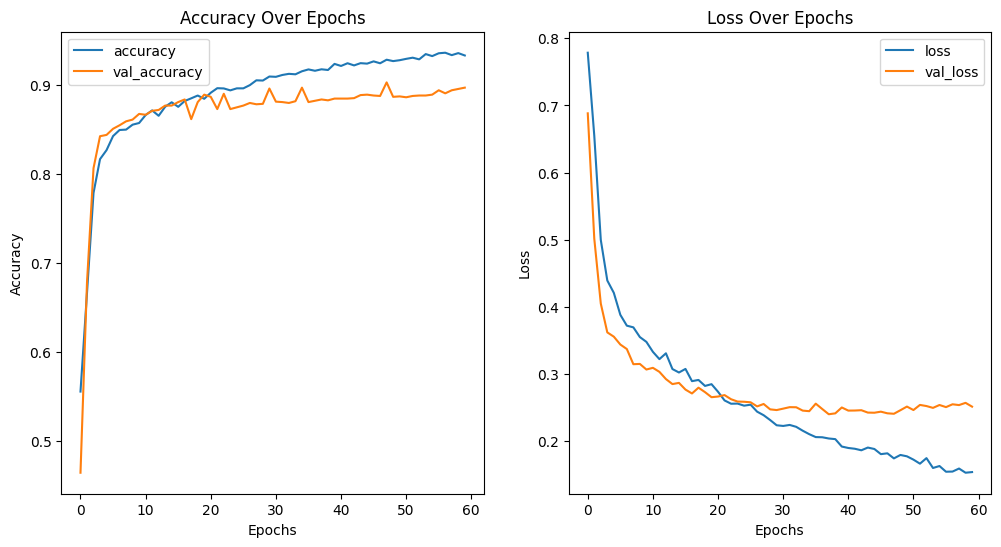

In [74]:
with open('training_history.pkl', 'rb') as file:
        history_list = pickle.load(file)
        
accuracy = [acc for epoch_history in history_list for acc in epoch_history['accuracy']]
val_accuracy = [val_acc for epoch_history in history_list for val_acc in epoch_history['val_accuracy']]
loss = [l for epoch_history in history_list for l in epoch_history['loss']]
val_loss = [val_l for epoch_history in history_list for val_l in epoch_history['val_loss']]

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(accuracy, label='accuracy')
plt.plot(val_accuracy, label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='loss')
plt.plot(val_loss, label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

162/162 [==============================] - 1s 5ms/step
Accuracy: 0.7951
Classification Report:
               precision    recall  f1-score   support

         ham       0.99      0.77      0.87      4510
        spam       0.38      0.95      0.54       653

    accuracy                           0.80      5163
   macro avg       0.68      0.86      0.70      5163
weighted avg       0.91      0.80      0.83      5163



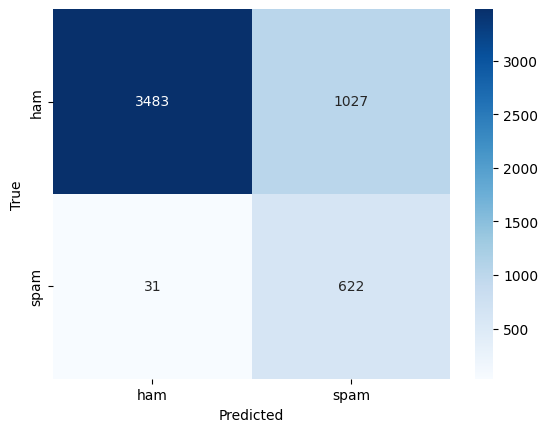

In [75]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from joblib import dump


# Load the trained model and vectorizer
try:
    dump(model, 'my_model.keras')
    with open('vectorizer.joblib', 'wb') as file:
        dump(vectorizer, file)
except Exception as e:
    print(f"Error loading model or vectorizer: {e}")
    # Add further error handling if needed

# Load the test dataset
try:
    test_data = pd.read_csv('test_dataset.csv', encoding='latin-1')
    test_data.drop_duplicates(inplace=True)
    test_data['v1'] = test_data['v1'].map({'spam': 1, 'ham': 0})
    test_data = test_data.dropna(subset=['v2'])
    test_data.drop_duplicates(inplace=True)
except Exception as e:
    print(f"Error loading test dataset: {e}")
    # Add further error handling if needed

# Make predictions
try:
    test_predictions = model.predict(vectorizer.transform(test_data['v2']))
except Exception as e:
    print(f"Error making predictions: {e}")
    # Add further error handling if needed

# Evaluate the model
accuracy = accuracy_score(test_data['v1'], (test_predictions > 0.5).astype(int))
print(f'Accuracy: {accuracy:.4f}')

# Classification Report
labels = ['ham', 'spam']
classification_rep = classification_report(test_data['v1'], (test_predictions > 0.5).astype(int), target_names=labels)
print('Classification Report:\n', classification_rep)

# Confusion Matrix
cm = confusion_matrix(test_data['v1'], (test_predictions > 0.5).astype(int))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
